# Digital Futures Academy Project: **Swan Teleco**

In [54]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler 
from sklearn import metrics

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [55]:
pd.set_option('display.max_columns',100)

In [56]:
# Read the data into a Pandas DataFrame
swan = pd.read_excel("1 - Project Data.xlsx")

In [57]:
swan.head()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,No,No,Yes,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,No,No,Yes,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,No,No,Yes,49,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,Competitor had better devices


## **EDA**

### Cleaning
* Redundant column removal
  * `Churn Label`
* Correcting data types
  * `Total Charges` --> object to float
* Null Value handling
  * Replace ' ' with 0 where `Total Charges == ' '`

In [58]:
# Check nulls and datatypes
swan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 31 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         7043 non-null   object 
 1   Count              7043 non-null   int64  
 2   Country            7043 non-null   object 
 3   State              7043 non-null   object 
 4   City               7043 non-null   object 
 5   Zip Code           7043 non-null   int64  
 6   Lat Long           7043 non-null   object 
 7   Latitude           7043 non-null   float64
 8   Longitude          7043 non-null   float64
 9   Gender             7043 non-null   object 
 10  Senior Citizen     7043 non-null   object 
 11  Partner            7043 non-null   object 
 12  Dependents         7043 non-null   object 
 13  Tenure Months      7043 non-null   int64  
 14  Phone Service      7043 non-null   object 
 15  Multiple Lines     7043 non-null   object 
 16  Internet Service   7043 

In [59]:
# Check there are no duplicates
len(swan) == len(swan.drop_duplicates())

True

In [60]:
# Check number of rows
swan.shape[0]

7043

In [61]:
# Check Churn Label is coded to Churn Value correctly
((swan['Churn Label'] == 'No')&(swan['Churn Value'] == 0)).sum() + ((swan['Churn Label'] == 'Yes')&(swan['Churn Value'] == 1)).sum()

7043

In [62]:
# Drop redundant column
swan.drop(columns = ['Churn Label'], inplace =True)

In [63]:
# Locate sneaky missing values in Total Charges
(swan['Total Charges'] == ' ').sum()

11

In [64]:
# Check that there's no inconsistancy with tenure
swan[swan['Total Charges'] == ' ']['Tenure Months']

2234    0
2438    0
2568    0
2667    0
2856    0
4331    0
4687    0
5104    0
5719    0
6772    0
6840    0
Name: Tenure Months, dtype: int64

In [65]:
# Rewrite missing ' ' as 0
swan['Total Charges'].replace(' ', 0, inplace=True)

C:\Users\Owner\AppData\Local\Temp\ipykernel_6164\3068935308.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  swan['Total Charges'].replace(' ', 0, inplace=True)
C:\Users\Owner\AppData\Local\Temp\ipykernel_6164\3068935308.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  swan['Total Charges'].re

In [66]:
# Prepare as float
swan['Total Charges'] = swan['Total Charges'].astype(float)

### Train-Test Split

In [67]:
feature_cols = list(swan.columns)
feature_cols.remove('Churn Value')

X = swan[feature_cols]
y = swan['Churn Value']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [68]:
# Check indexes line up
(X_train.index != y_train.index).sum()

0

### Explore Target

In [69]:
train = X_train.copy()
train['Churn Value'] = y_train.copy()


In [70]:
train['Churn Value'].value_counts(normalize = True)

Churn Value
0    0.739262
1    0.260738
Name: proportion, dtype: float64

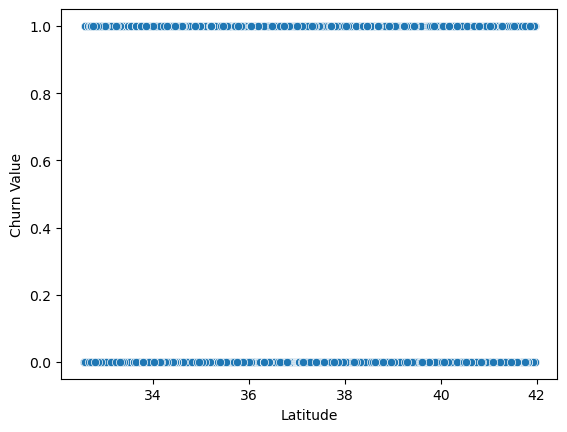

In [71]:
sns.scatterplot(data=train, x='Latitude', y='Churn Value')
plt.show()

### Churner Demographic

### Finding relationships

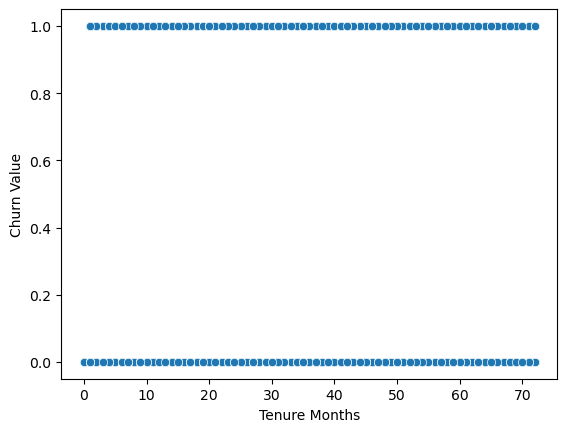

In [72]:
sns.scatterplot(train, x='Tenure Months', y='Churn Value')
plt.show()

## **Feature Engineering**

* Drop from Feature List: `CustomerID`,`Count`,`Country`,`State`,`City`,`Zip Code`,`Lat Long`,`Churn Reason`
> These are multicollinear with other variables 
* Boolean Label Encode: `Gender`,`Senior Citizen`,`Partner`,`Dependents`,`Phone Service`,`Paperless Billing`,`Multiple Lines`,`Online Security`,`Online Backup`,`Device Protection`,`Tech Support`,`Streaming TV`,`Streaming Movies`
* Order Label Encode: `Contract`
* One-Hot Encode: `Internet Service`,`Payment Method`
* Feature Scaling: Max-Min Scale every feature

In [73]:
def bool_labeling(df, col_name):
    df = df.copy()
    col = df[col_name].replace({r'^No.*':0,'Yes':1,0:0,1:1}, regex=True)
    return col

In [74]:
def gender_labeling(df, col_name):
    df = df.copy()
    col = df[col_name].replace({'Male':0,'Female':1,0:0,1:1})
    return col

In [75]:
def contract_labeling(df, col_name):
    df=df.copy()
    col = df[col_name].replace({'One year':12,'Month-to-month':1,'Two year':24})
    return col

In [76]:
def ohe(df, col_name):
    df=df.copy()
    df=pd.get_dummies(df, columns = [f'{col_name}'], prefix = f'{col_name}', drop_first = True, dtype='int')
    return df

In [77]:
def feature_engineering(df):
    df=df.copy()

    df = sm.add_constant(df)
    
    df.drop(columns=['Count','Country','State','City','Zip Code','Lat Long','Churn Reason'],inplace = True)

    for col_name in ['Senior Citizen','Partner','Dependents','Phone Service','Paperless Billing','Multiple Lines',
                     'Online Security','Online Backup','Device Protection','Tech Support','Streaming TV',
                     'Streaming Movies']:
        df[col_name] = bool_labeling(df, col_name)

    df['Gender'] = gender_labeling(df, 'Gender')
    df['Contract'] = contract_labeling(df, 'Contract')

    df = ohe(df,'Internet Service')
    df = ohe(df,'Payment Method')

    return df
    

In [78]:
# Drop customer ID indepedently so that it can be set as an index for the final predictions
X_train.drop(columns='CustomerID',inplace=True)

In [79]:
X_test.drop(columns='CustomerID',inplace=True)

In [80]:
X_train_fe = feature_engineering(X_train)

C:\Users\Owner\AppData\Local\Temp\ipykernel_6164\2918864045.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  col = df[col_name].replace({r'^No.*':0,'Yes':1,0:0,1:1}, regex=True)


### Scaling

In [81]:
train_minmax = MinMaxScaler() ## Initialise scaler
train_minmax.fit(X_train_fe)

MinMaxScaler()

In [82]:
def max_min(df):
    global train_minmax
    df=df.copy()
    df = train_minmax.transform(df)
    return df

In [83]:
X_train_fe_scaled = pd.DataFrame(max_min(X_train_fe), index = X_train_fe.index, columns = X_train_fe.columns)

In [84]:
X_train_fe_scaled.head()

,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Monthly Charges,Total Charges,Internet Service_Fiber optic,Internet Service_No,Payment Method_Credit card (automatic),Payment Method_Electronic check,Payment Method_Mailed check
2142,0.026273,0.719622,0.0,0.0,1.0,0.0,0.986111,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.478261,1.0,0.801196,0.801728,1.0,0.0,1.0,0.0,0.0
1623,0.562589,0.377385,1.0,0.0,0.0,0.0,0.222222,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.000000,1.0,0.746886,0.181202,1.0,0.0,1.0,0.0,0.0
6074,0.207249,0.627822,1.0,0.0,0.0,0.0,0.444444,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.478261,1.0,0.855007,0.393429,1.0,0.0,1.0,0.0,0.0
1362,0.162030,0.618756,1.0,1.0,1.0,0.0,0.333333,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.000000,1.0,0.223219,0.107464,0.0,0.0,1.0,0.0,0.0
6754,0.152314,0.590326,1.0,0.0,1.0,1.0,0.277778,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.017937,0.046754,0.0,1.0,0.0,0.0,1.0


### Feature Selection

In [85]:
## This a piece of code from stats.stackexchange.com

## It runs the model with all the variables.
## If any of them have a higher VIF than 4, it drops the max. 
## Then it keeps going until none of them have a higher VIF than 5.
## This leaves us with a nice set of features with no collineraity

def calculate_vif(X, thresh = 13.0):
    variables = list(range(X.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        # this bit uses list comprehension to gather all the VIF values of the different variables
        vif = [variance_inflation_factor(X.iloc[:, variables].values, ix)
               for ix in range(X.iloc[:, variables].shape[1])]
        
        maxloc = vif.index(max(vif)) # getting the index of the highest VIF value
        if max(vif) > thresh:
            print('dropping \'' + X.iloc[:, variables].columns[maxloc] +
                  '\' at index: ' + str(maxloc))
            del variables[maxloc] # we delete the highest VIF value on condition that it's higher than the threshold
            dropped = True # if we deleted anything, we set the 'dropped' value to True to stay in the while loop

    print('Remaining variables:')
    return list(X.columns[variables]) # finally, we print the variables that are still in our set
   

In [86]:
#def calculate_vif(X):
  #  X = sm.add_constant(X)    # Adds a constant to DataFrame X so that the function "variance_inflation_factor" can perform its tests
  #  vif_data = pd.DataFrame()    # Creates DataFrame that will be used to visualize vif data
   # vif_data['Variable'] = X.columns
   # vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
   # return vif_data

In [87]:
selected_features = calculate_vif(X_train_fe_scaled)

dropping 'Monthly Charges' at index: 17
dropping 'Total Charges' at index: 17
Remaining variables:


In [88]:
def feature_selection(df):
    global selected_features
    df=df.copy()
    df=df[selected_features]
    df.drop(columns=['Payment Method_Mailed check','Payment Method_Credit card (automatic)',
                      'Device Protection','Online Backup','Senior Citizen','Gender','Longitude',
                      'Latitude'],inplace=True)
    return df

In [89]:
X_train_final = feature_selection(X_train_fe_scaled)

## **Modeling**

In [90]:
#lr = LogisticRegression(max_iter=300, random_state=10)

In [49]:
#lr.fit(X_train_fe_scaled, y_train)

In [50]:
#results = pd.DataFrame()
#results[['prob_stay', 'prob_leave']] = lr.predict_proba(X_train_fe_scaled)

In [51]:
#results['y_pred'] = np.where(results['prob_leave']>.5, 1, 0)

In [53]:
#get_results(y_train, results['y_pred'])

## **Evaluation**

In [55]:
#X_test_fe = feature_engineering(X_test)

In [56]:
#X_test_fe_scaled = pd.DataFrame(max_min(X_test_fe), index = X_test_fe.index, columns = X_test_fe.columns)

In [57]:
#results_test = pd.DataFrame()
#results_test[['prob_stay', 'prob_leave']] = lr.predict_proba(X_test_fe_scaled)

In [58]:
#results_test['y_pred'] = np.where(results_test['prob_leave']>.5, 1, 0)

In [59]:
#get_results(y_test, results_test['y_pred'])

## **Modeling (StatsModels)**

In [91]:
log_reg = sm.Logit(y_train, X_train_final)

In [92]:
result = log_reg.fit()

Optimization terminated successfully.
         Current function value: 0.397596
         Iterations 7


In [93]:
print(result.summary())

                           Logit Regression Results                           
Dep. Variable:            Churn Value   No. Observations:                 5634
Model:                          Logit   Df Residuals:                     5620
Method:                           MLE   Df Model:                           13
Date:                Tue, 22 Jul 2025   Pseudo R-squ.:                  0.3071
Time:                        16:59:30   Log-Likelihood:                -2240.1
converged:                       True   LL-Null:                       -3232.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Partner                             0.2635      0.085      3.112      0.002       0.098       0.429
Dependents                         -1.4859      0.131    -11.374    

### **Choose your threshold**

In [94]:
##################
threshold = 0.5
##################

In [95]:
results = pd.DataFrame()
results['y_train_prob'] = result.predict(X_train_final)
results['y_train_pred'] = (results['y_train_prob']>threshold).astype(int)
results['y_train'] = y_train
results.head()

,y_train_prob,y_train_pred,y_train
2142,0.168621,0,0
1623,0.556386,1,1
6074,0.406253,0,0
1362,0.475071,0,1
6754,0.034248,0,0


In [97]:
def get_results(actual, predicted):
    print("The confusion matrix for your predictions is:")
    print(metrics.confusion_matrix(actual, predicted), "\n")
    print(f'The accuracy of your model is: {metrics.accuracy_score(actual, predicted)}')
    print(f'The recall of your model is: {metrics.recall_score(actual, predicted)}')
    print(f'The precision of your model is: {metrics.precision_score(actual, predicted)}')
    print(f'The F1-score of your model is: {metrics.f1_score(actual, predicted)}')

In [98]:
get_results(results.y_train,results.y_train_pred)

The confusion matrix for your predictions is:
[[3742  423]
 [ 629  840]] 

The accuracy of your model is: 0.8132765353212638
The recall of your model is: 0.5718175629680055
The precision of your model is: 0.665083135391924
The F1-score of your model is: 0.6149341142020498


## **Evaluation (StatsModels)**

In [102]:
X_test_fe = feature_engineering(X_test)

C:\Users\Owner\AppData\Local\Temp\ipykernel_6164\2918864045.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  col = df[col_name].replace({r'^No.*':0,'Yes':1,0:0,1:1}, regex=True)


In [103]:
X_test_fe_scaled = pd.DataFrame(max_min(X_test_fe), index = X_test_fe.index, columns = X_test_fe.columns)

In [104]:
X_test_fe_scaled.drop(columns=['Monthly Charges','Total Charges'],inplace=True)

In [105]:
X_test_final = feature_selection(X_test_fe_scaled)

In [106]:
results_test = pd.DataFrame()
results_test['y_test_prob'] = result.predict(X_test_final)
results_test['y_test_pred'] = (results_test['y_test_prob']>threshold).astype(int)
results_test['y_test'] = y_test
results_test.head()

,y_test_prob,y_test_pred,y_test
185,0.565728,1,1
2715,0.358232,0,0
3825,0.250376,0,0
1807,0.767080,1,1
132,0.328616,0,1


In [107]:
get_results(results_test.y_test,results_test.y_test_pred)

The confusion matrix for your predictions is:
[[899 110]
 [168 232]] 

The accuracy of your model is: 0.8026969481902059
The recall of your model is: 0.58
The precision of your model is: 0.6783625730994152
The F1-score of your model is: 0.6253369272237197


C:\Users\Owner\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Owner\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Owner\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Owner\anaconda3\Lib\site-packages\sklearn\metrics\_clas

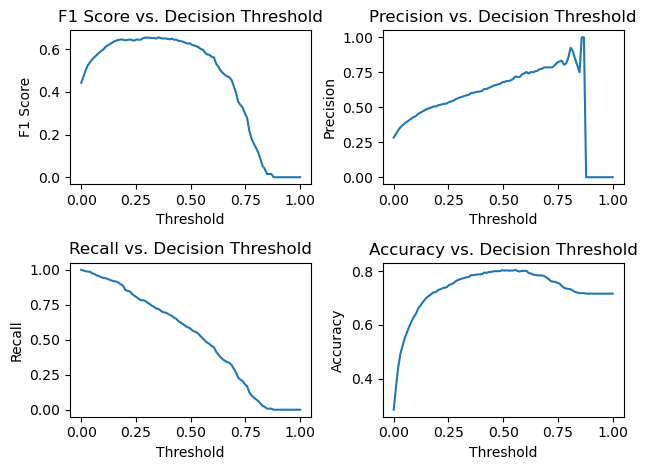

In [108]:
thresholds = np.linspace(0, 1, 100)
f1s = [metrics.f1_score(y_test, (results_test.y_test_prob>t).astype(int)) for t in thresholds]
precisions = [metrics.precision_score(y_test, (results_test.y_test_prob>t).astype(int)) for t in thresholds]
recalls = [metrics.recall_score(y_test, (results_test.y_test_prob>t).astype(int)) for t in thresholds]
accuracies = [metrics.accuracy_score(y_test, (results_test.y_test_prob>t).astype(int)) for t in thresholds]

plt.subplot(2,2,1)
sns.lineplot(x=thresholds,y = f1s)
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("F1 Score vs. Decision Threshold")


plt.subplot(2,2,2)
sns.lineplot(x=thresholds, y = precisions)
plt.xlabel("Threshold")
plt.ylabel("Precision")
plt.title("Precision vs. Decision Threshold")

plt.subplot(2,2,3)
sns.lineplot(x=thresholds, y= recalls)
plt.xlabel("Threshold")
plt.ylabel("Recall")
plt.title("Recall vs. Decision Threshold")

plt.subplot(2,2,4)
sns.lineplot(x=thresholds, y=accuracies)
plt.xlabel("Threshold")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Decision Threshold")

    
plt.tight_layout()

In [109]:
print(f"Precision: {thresholds[np.argmax(precisions)]:.2f}")
print(f"Recall: {thresholds[np.argmax(recalls)]:.2f}")
print(f"Accuracy: {thresholds[np.argmax(accuracies)]:.2f}")

Precision: 0.86
Recall: 0.00
Accuracy: 0.56


# **Gathering top 500 Likely to Churn**

### Joining up feature engineered sets - they're ready to predict
* But remove already churned

In [139]:
mask = swan['Churn Value'] == 1

In [140]:
# Drop all customers who have already left
swan_remain = swan[~mask]

In [141]:
# Amount of remaining customers
len(swan_remain)

5174

In [142]:
# Feature engineer data for model prediction
swan_remain_fe = feature_engineering(swan_remain)

C:\Users\Owner\anaconda3\Lib\site-packages\numpy\core\_methods.py:41: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
C:\Users\Owner\anaconda3\Lib\site-packages\numpy\core\_methods.py:45: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
C:\Users\Owner\AppData\Local\Temp\ipykernel_6164\2918864045.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  col = df[col_name].replace({r'^No.*':0,'Yes':1,0:0,1:1}, regex=True)


In [143]:
# Set customerID as index to identify customers
swan_remain_fe.set_index('CustomerID',inplace=True)

In [144]:
# Drop target column
swan_remain_fe.drop(columns='Churn Value',inplace=True)

In [145]:
# Same columns as feature selection + the ones dropped by VIF selection
swan_remain_fe.drop(columns=['Payment Method_Mailed check','Payment Method_Credit card (automatic)',
                      'Device Protection','Online Backup','Senior Citizen','Gender','Longitude',
                      'Latitude','Monthly Charges','Total Charges'],inplace=True)


In [146]:
# Minmax rescaling based on all data
minmax = MinMaxScaler() ## Initialise scaler
minmax.fit(swan_remain_fe)

MinMaxScaler()

In [147]:
swan_remain_fe_scaled = swan_remain_fe.copy()

In [148]:
swan_remain_fe_scaled[list(swan_remain_fe.columns)] = minmax.transform(swan_remain_fe[list(swan_remain_fe.columns)])

In [149]:
swan_remain_fe_scaled.head()

,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Online Security,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Internet Service_Fiber optic,Internet Service_No,Payment Method_Electronic check
CustomerID,,,,,,,,,,,,,,
7590-VHVEG,1.0,0.0,0.013889,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,1.0
5575-GNVDE,0.0,0.0,0.472222,1.0,0.0,1.0,0.0,0.0,0.0,0.478261,0.0,0.0,0.0,0.0
7795-CFOCW,0.0,0.0,0.625000,0.0,0.0,1.0,1.0,0.0,0.0,0.478261,0.0,0.0,0.0,0.0
1452-KIOVK,0.0,1.0,0.305556,1.0,1.0,0.0,0.0,1.0,0.0,0.000000,1.0,1.0,0.0,0.0
6713-OKOMC,0.0,0.0,0.138889,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [150]:
X_test_final.head()

,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Online Security,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Internet Service_Fiber optic,Internet Service_No,Payment Method_Electronic check
185,0.0,0.0,0.208333,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
2715,1.0,0.0,0.250000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3825,0.0,0.0,0.027778,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1807,1.0,0.0,0.083333,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0
132,0.0,0.0,0.555556,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0


In [151]:
# Create a new dataFrame with remaining customer's probabilities
remain_list = pd.DataFrame()
remain_list['Churn Probability'] = result.predict(swan_remain_fe_scaled)

In [152]:
# Sort probabilities to 500 most at risk
Most_at_risk = remain_list.sort_values('Churn Probability',ascending=False).head(500)[['Churn Probability']]

In [156]:
# Export to csv
Most_at_risk.to_csv('most_at_risk.csv')

In [157]:
# Remaining customer's probabilities
Least_at_risk = remain_list.sort_values('Churn Probability',ascending=False).head(len(swan_remain)-500)[['Churn Probability']]

In [158]:
# Export to csv
Least_at_risk.to_csv('least_at_risk.csv')